In [1]:
import os
import shutil
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter
import math
from math import floor
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [2]:
def display_data(parent_dir):
    # Step 1: Directory to disease mapping
    condition_types = {
        'Acitinic Keratosis': 'Precancerous',
        'Basal Cell Carcinoma': 'Cancerous',
        'Dermatofibroma': 'Non-cancerous',
        'Melanoma': 'Cancerous',
        'Nevus': 'Non-cancerous',
        'Pigmented Benign Keratosis': 'Non-cancerous',
        'Seborrheic Keratosis': 'Non-cancerous',
        'Squamous Cell Carcinoma': 'Cancerous',
        'Vascular Lesion': 'Non-cancerous'
    }

    # Step 2: Create a DataFrame with directory names and image counts
    data = {'Directory': [], 'File Count': [], 'Condition Type': []}

    # Step 3: Loop through directories, count images, and add condition type
    for dirpath, dirnames, filenames in os.walk(parent_dir):
        if dirpath != parent_dir:
            dir_name = os.path.basename(dirpath)
            file_count = len(filenames)
            condition_type = condition_types.get(dir_name, 'Unknown')  # Get the condition type from the mapping
            data['Directory'].append(dir_name)
            data['File Count'].append(file_count)
            data['Condition Type'].append(condition_type)

    # Create DataFrame
    df = pd.DataFrame(data)
    # Step 4: Add the color mapping
    colors = {'Cancerous': 'red', 'Precancerous': 'yellow', 'Non-cancerous': 'green'}

    # Set up the bar plot
    plt.figure(figsize=(10,6))
    bars = plt.bar(df['Directory'], df['File Count'], color=[colors[ctype] for ctype in df['Condition Type']])

    # Add title and labels
    plt.title('Number of Image per Skin Condition', fontsize=14)
    plt.xlabel('Skin Disease', fontsize=12)
    plt.ylabel('Image Count', fontsize=12)

    # Add a legend
    handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors.values()]
    labels = colors.keys()
    plt.legend(handles, labels, title="Condition Type")

    # Show the plot
    plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
    plt.tight_layout()
    plt.show()

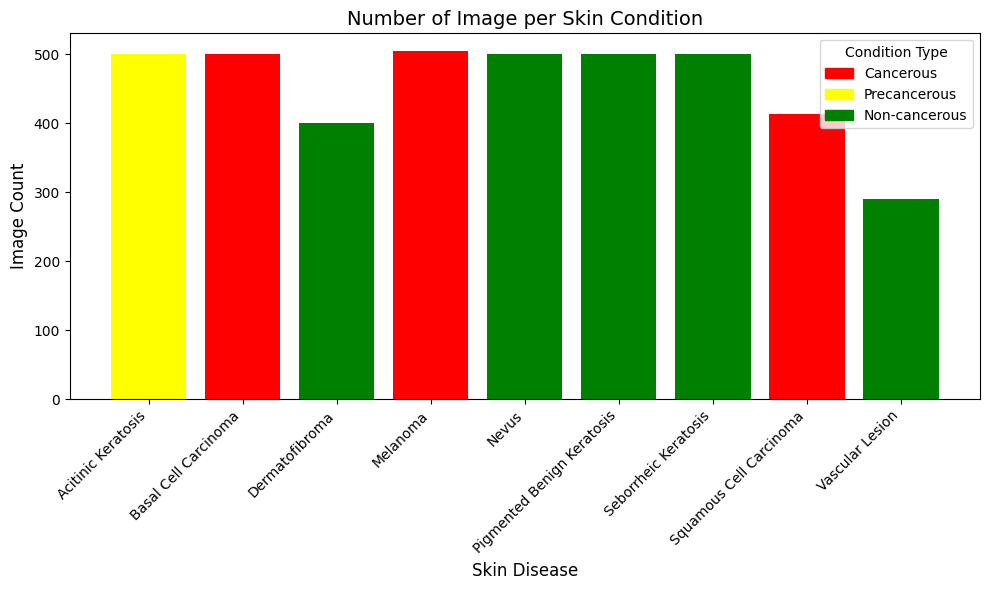

In [3]:
display_data(parent_dir = 'Skin Cancer Dataset')

Displaying images for category: Acitinic Keratosis


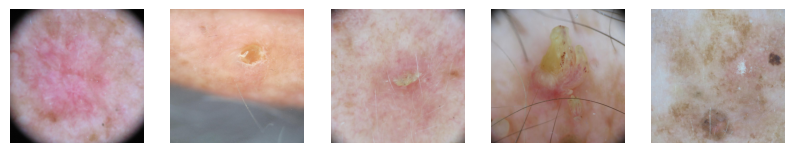

Displaying images for category: Basal Cell Carcinoma


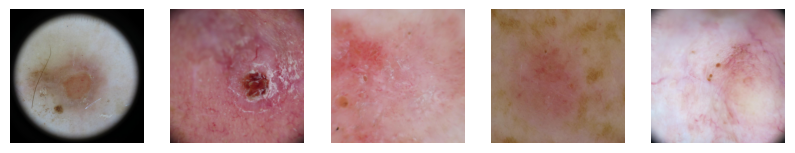

Displaying images for category: Dermatofibroma


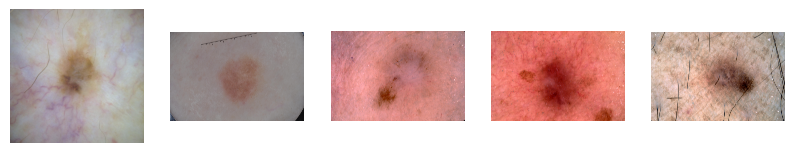

Displaying images for category: Melanoma


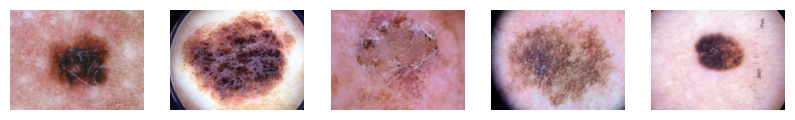

Displaying images for category: Nevus


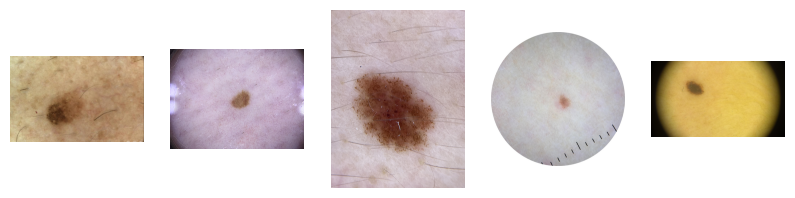

Displaying images for category: Pigmented Benign Keratosis


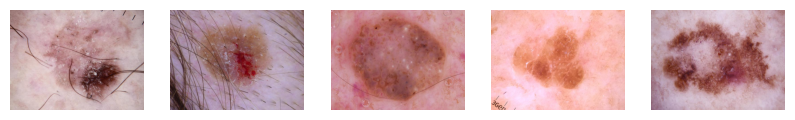

Displaying images for category: Seborrheic Keratosis


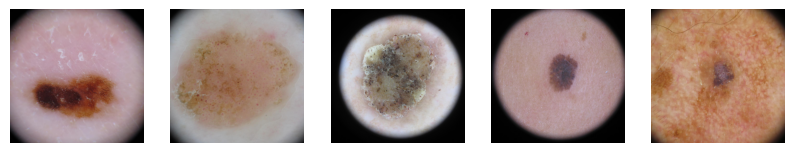

Displaying images for category: Squamous Cell Carcinoma


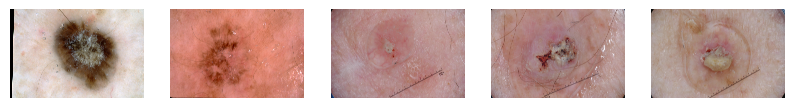

Displaying images for category: Vascular Lesion


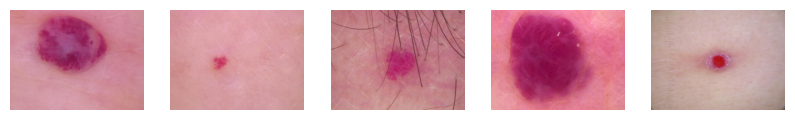

In [4]:
parent_dir = 'Skin Cancer Dataset'

# Automatically retrieve the list of categories (subdirectories) from the parent directory
categories = [d for d in os.listdir(parent_dir) if os.path.isdir(os.path.join(parent_dir, d))]

# Function to display images from each category
def display_images_for_category(category_dir, num_images=5):
    image_files = [f for f in os.listdir(category_dir)]
    
    # Only proceed if there are images to display
    if len(image_files) == 0:
        print(f"No images found in {category_dir}. Skipping...")
        return
    
    # Display at least 5 images or all if fewer are available
    image_files = image_files[:num_images]
    
    # Set up the figure to display images
    fig, axes = plt.subplots(1, len(image_files), figsize=(10, 5))
    
    # If there's only one image, axes is not a list, handle that case
    if len(image_files) == 1:
        axes = [axes]
    
    # Display each image
    for i, image_file in enumerate(image_files):
        img_path = os.path.join(category_dir, image_file)
        img = mpimg.imread(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')  # Hide axes
#         axes[i].set_title(f'{os.path.basename(category_dir)}')

    plt.show()

# Loop through each category and display at least 5 images
for category in categories:
    category_dir = os.path.join(parent_dir, category)
    if os.path.exists(category_dir):  # Check if the directory exists
        print(f"Displaying images for category: {category}")
        display_images_for_category(category_dir, num_images=5)
    else:
        print(f"Directory not found: {category_dir}")

Image Properties:
Filename: ISIC_0066262.JPG
Format: JPEG
Mode: RGB
Size: (1024, 1024)
Width: 1024
Height: 1024
Info: {'jfif': 257, 'jfif_version': (1, 1), 'jfif_unit': 0, 'jfif_density': (1, 1)}


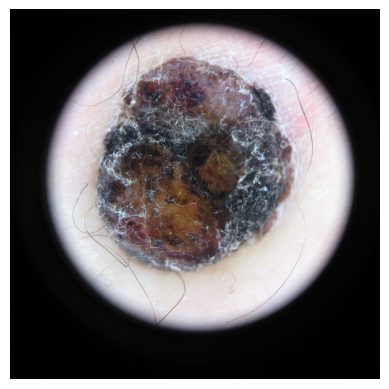

In [5]:
def get_image_properties(image_path):
    try:
        # Open the image file
        with Image.open(image_path) as img:
            # Get image properties
            properties = {
                'Filename': os.path.basename(image_path),
                'Format': img.format,
                'Mode': img.mode,
                'Size': img.size,  # (width, height)
                'Width': img.width,
                'Height': img.height,
                'Info': img.info,  # Additional metadata
            }
            # Convert the image to a NumPy array for displaying
            img_array = np.array(img)
            return properties, img_array  # Return properties and image array
    except Exception as e:
        print(f"Error opening image: {e}")
        return None, None

def display_image(image):
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()

# Example usage
image_path = "Skin Cancer Dataset/Melanoma/ISIC_0066262.JPG"  # Specify image path
properties, image = get_image_properties(image_path)

if properties:
    print("Image Properties:")
    for key, value in properties.items():
        print(f"{key}: {value}")
    
    # Display the image
    display_image(image)

DATA AUGMENTATION

Image Resizing

In [6]:
# Define the paths
source_directory = 'Skin Cancer Dataset'  # Source dataset directory containing class subdirectories
target_directory = 'Dataset'  # Target directory to save resized images
target_size = (224, 224)  # Target size for resizing

# Create the target directory if it doesn't exist
if not os.path.exists(target_directory):
    os.makedirs(target_directory)

# Function to resize images and save them in the target directory
def resize_images_and_save(source_dir, target_dir, size):
    # Loop through each subdirectory (class) in the source directory
    for class_dir in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_dir)
        target_class_path = os.path.join(target_dir, class_dir)

        if os.path.isdir(class_path):  # Check if it's a directory (class)
            # Create the corresponding class directory in the target directory
            if not os.path.exists(target_class_path):
                os.makedirs(target_class_path)

            print(f"Processing class: {class_dir}")

            # Loop through each image file in the class directory
            for filename in os.listdir(class_path):
                img_path = os.path.join(class_path, filename)
                target_img_path = os.path.join(target_class_path, filename)

                try:
                    # Open and resize the image
                    with Image.open(img_path) as img:
                        resized_img = img.resize(size)

                        # Save the resized image to the target directory
                        resized_img.save(target_img_path)
#                         print(f"Resized and saved {filename} to {target_img_path}")

                except Exception as e:
                    print(f"Error processing file {filename}: {e}")

# Call the function to resize images and save them to the target directory
resize_images_and_save(source_directory, target_directory, target_size)

Processing class: Acitinic Keratosis
Processing class: Basal Cell Carcinoma
Processing class: Dermatofibroma
Error processing file metadata.csv: cannot identify image file 'C:\\Users\\krish\\OneDrive\\Desktop\\DATA SCIENCE\\DEEP LEARNING\\Skin Cancer\\Skin Cancer Dataset\\Dermatofibroma\\metadata.csv'
Processing class: Melanoma
Processing class: Nevus
Processing class: Pigmented Benign Keratosis
Processing class: Seborrheic Keratosis
Processing class: Squamous Cell Carcinoma
Processing class: Vascular Lesion
Error processing file metadata.csv: cannot identify image file 'C:\\Users\\krish\\OneDrive\\Desktop\\DATA SCIENCE\\DEEP LEARNING\\Skin Cancer\\Skin Cancer Dataset\\Vascular Lesion\\metadata.csv'


Visualizing Resized Skin Disease Images

Displaying images for category: Acitinic Keratosis


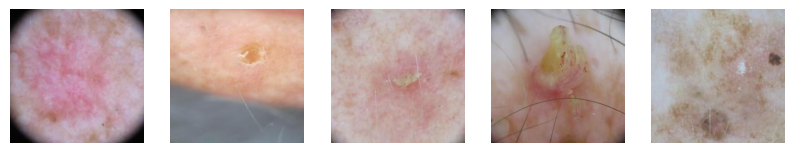

Displaying images for category: Basal Cell Carcinoma


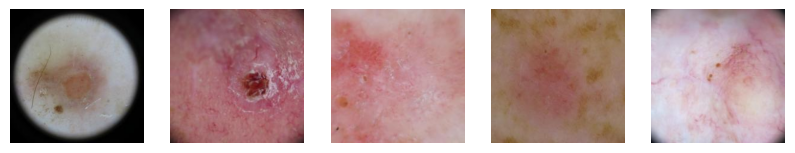

Displaying images for category: Dermatofibroma


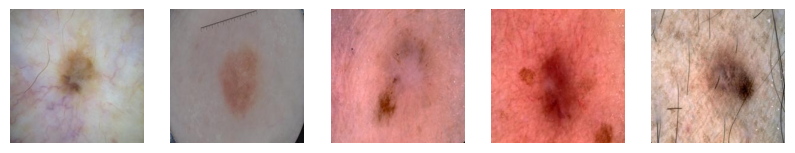

Displaying images for category: Melanoma


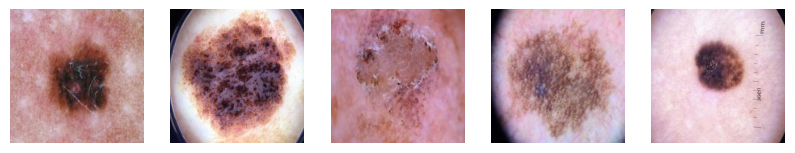

Displaying images for category: Nevus


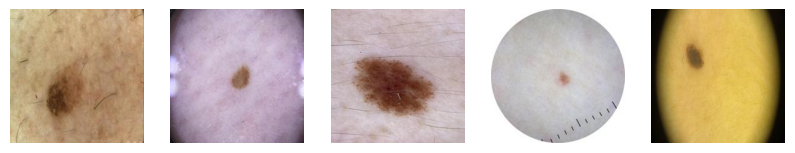

Displaying images for category: Pigmented Benign Keratosis


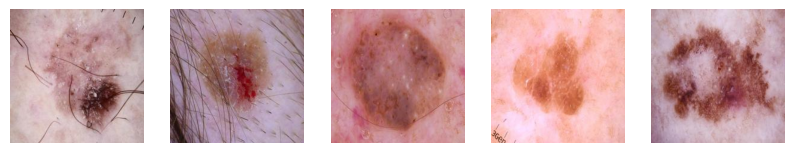

Displaying images for category: Seborrheic Keratosis


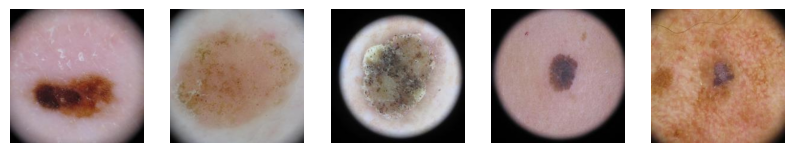

Displaying images for category: Squamous Cell Carcinoma


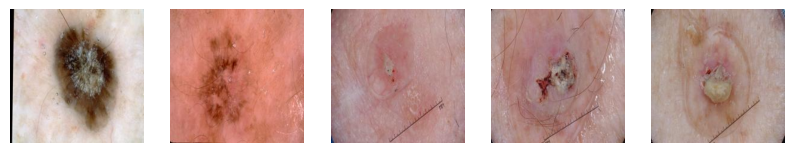

Displaying images for category: Vascular Lesion


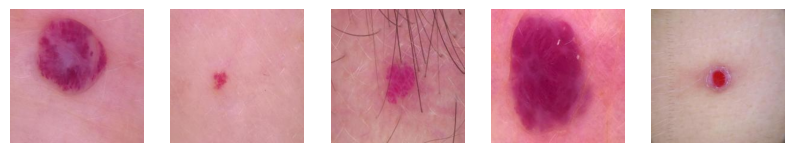

In [7]:
parent_dir = 'Dataset'

# Automatically retrieve the list of categories (subdirectories) from the parent directory
categories = [d for d in os.listdir(parent_dir) if os.path.isdir(os.path.join(parent_dir, d))]

# Function to display images from each category
def display_images_for_category(category_dir, num_images=5):
    image_files = [f for f in os.listdir(category_dir)]
    
    # Only proceed if there are images to display
    if len(image_files) == 0:
        print(f"No images found in {category_dir}. Skipping...")
        return
    
    # Display at least 5 images or all if fewer are available
    image_files = image_files[:num_images]
    
    # Set up the figure to display images
    fig, axes = plt.subplots(1, len(image_files), figsize=(10, 5))
    
    # If there's only one image, axes is not a list, handle that case
    if len(image_files) == 1:
        axes = [axes]
    
    # Display each image
    for i, image_file in enumerate(image_files):
        img_path = os.path.join(category_dir, image_file)
        img = mpimg.imread(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')  # Hide axes
#         axes[i].set_title(f'{os.path.basename(category_dir)}')

    plt.show()

# Loop through each category and display at least 5 images
for category in categories:
    category_dir = os.path.join(parent_dir, category)
    if os.path.exists(category_dir):  # Check if the directory exists
        print(f"Displaying images for category: {category}")
        display_images_for_category(category_dir, num_images=5)
    else:
        print(f"Directory not found: {category_dir}")

IMAGE Augmentation
1.Horizontal Flip
2.Vertical Flip
3.Random Rotation (Between -30 to 30 degree)
4.Random Contrast Adjustment
5.Gaussain Blur

In [8]:
# Define the paths
source_directory = 'Dataset'  # Source dataset directory containing class subdirectories
target_directory = 'Data_Augmentation'  # Target directory to save augmented images

# Create the target directory if it doesn't exist
if not os.path.exists(target_directory):
    os.makedirs(target_directory)

# Data augmentation function
def augment_image(img):
    # List of augmentation transformations
    augmentations = [
        lambda x: x.transpose(Image.FLIP_LEFT_RIGHT),  # Horizontal flip
        lambda x: x.transpose(Image.FLIP_TOP_BOTTOM),  # Vertical flip
        lambda x: x.rotate(random.randint(-30, 30)),   # Random rotation between -30 to 30 degrees
        lambda x: ImageEnhance.Brightness(x).enhance(random.uniform(0.7, 1.3)),  # Random brightness adjustment
        lambda x: ImageEnhance.Contrast(x).enhance(random.uniform(0.7, 1.3)),    # Random contrast adjustment
        lambda x: ImageEnhance.Color(x).enhance(random.uniform(0.7, 1.3)),       # Random saturation adjustment
        lambda x: x.filter(ImageFilter.GaussianBlur(radius=random.uniform(0, 2)))  # Gaussian blur
    ]
    
    # Randomly apply 2-3 augmentations
    aug_img = img.copy()
    for _ in range(random.randint(2, 3)):
        aug_img = random.choice(augmentations)(aug_img)

    return aug_img

# Function to perform data augmentation on all images and save them
def augment_images_and_save(source_dir, target_dir, augmentations_per_image=7):
    # Loop through each subdirectory (class) in the source directory
    for class_dir in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_dir)
        target_class_path = os.path.join(target_dir, class_dir)

        if os.path.isdir(class_path):  # Check if it's a directory (class)
            # Create the corresponding class directory in the target directory
            if not os.path.exists(target_class_path):
                os.makedirs(target_class_path)

            print(f"Processing class: {class_dir}")

            # Loop through each image file in the class directory
            for filename in os.listdir(class_path):
                img_path = os.path.join(class_path, filename)
                base, ext = os.path.splitext(filename)

                try:
                    # Open the original image
                    with Image.open(img_path) as img:
                        # Save the original image to the target directory
                        original_img_path = os.path.join(target_class_path, f"{base}_original{ext}")
                        img.save(original_img_path)
#                         print(f"Saved original image: {base}_original{ext}")

                        # Generate augmented images
                        for i in range(augmentations_per_image):
                            aug_img = augment_image(img)
                            aug_img.save(os.path.join(target_class_path, f"{base}_augmented_{i+1}{ext}"))
#                             print(f"Saved {base}_augmented_{i+1}{ext}")

                except Exception as e:
                    print(f"Error processing file {filename}: {e}")

# Call the function to perform augmentation on all images
augment_images_and_save(source_directory, target_directory, augmentations_per_image=7)

Processing class: Acitinic Keratosis
Processing class: Basal Cell Carcinoma
Processing class: Dermatofibroma
Processing class: Melanoma
Processing class: Nevus
Processing class: Pigmented Benign Keratosis
Processing class: Seborrheic Keratosis
Processing class: Squamous Cell Carcinoma
Processing class: Vascular Lesion


Splitting Data in Train, Test and Validation Sets

In [9]:
def split_dataset(dataset_dir, output_dir, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    # Create output directories for train, val, test sets
    train_dir = os.path.join(output_dir, 'Train')
    val_dir = os.path.join(output_dir, 'Validation')
    test_dir = os.path.join(output_dir, 'Test')

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Loop through each class (directory) in the dataset
    for class_name in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        
        # List all image files in the class directory
        image_files = os.listdir(class_dir)
        
        # Shuffle the images randomly
        random.shuffle(image_files)
        
        # Calculate the split indices
        total_images = len(image_files)
        train_count = floor(total_images * train_ratio)
        val_count = floor(total_images * val_ratio)
        test_count = total_images - train_count - val_count  # The rest goes to test

        # Split the images
        train_files = image_files[:train_count]
        val_files = image_files[train_count:train_count + val_count]
        test_files = image_files[train_count + val_count:]

        # Copy files to the appropriate directories
        for file in train_files:
            src = os.path.join(class_dir, file)
            dest = os.path.join(train_dir, class_name)
            os.makedirs(dest, exist_ok=True)
            shutil.copy(src, dest)

        for file in val_files:
            src = os.path.join(class_dir, file)
            dest = os.path.join(val_dir, class_name)
            os.makedirs(dest, exist_ok=True)
            shutil.copy(src, dest)

        for file in test_files:
            src = os.path.join(class_dir, file)
            dest = os.path.join(test_dir, class_name)
            os.makedirs(dest, exist_ok=True)
            shutil.copy(src, dest)

    print("Dataset successfully split into train, validation, and test sets.")

#  Usage
dataset_dir = 'Data_Augmentation' 
output_dir = ''

split_dataset(dataset_dir, output_dir)

Dataset successfully split into train, validation, and test sets.


Display Directory Information

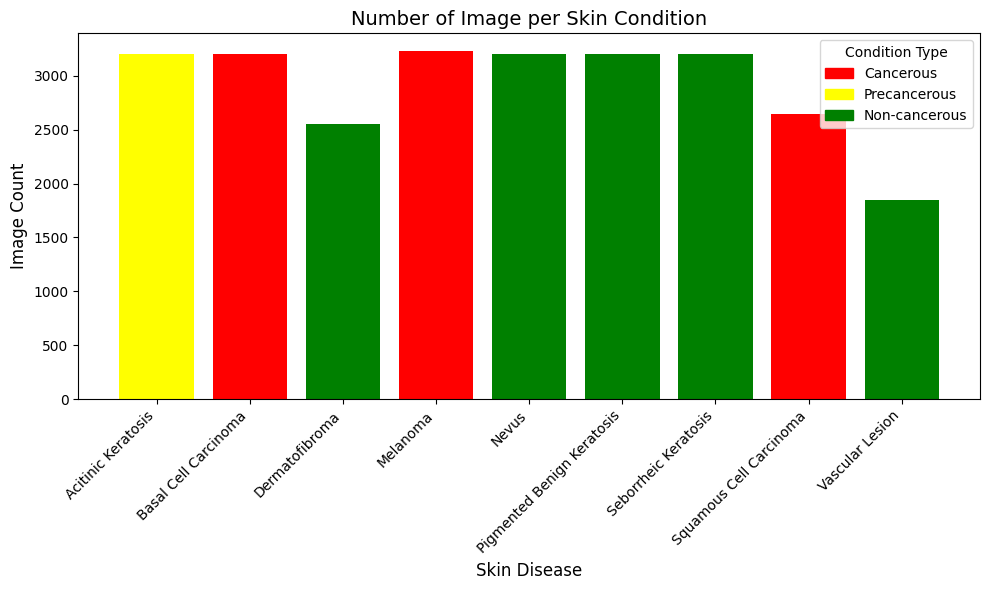

In [10]:
display_data(parent_dir='Train')

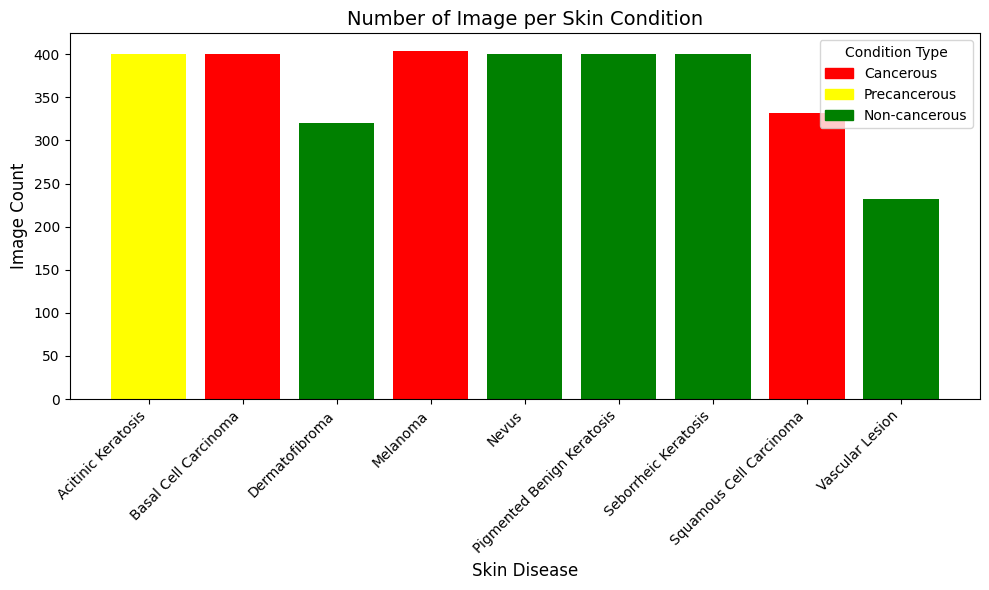

In [11]:
display_data(parent_dir='Test')

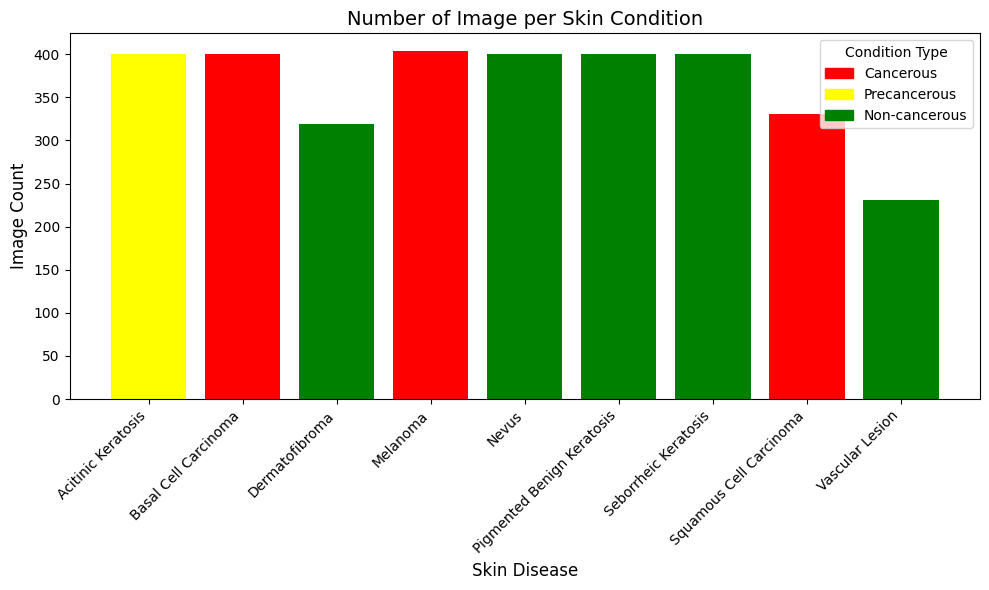

In [13]:
display_data(parent_dir='Validation')

3.8. Display Data Augmentated Skin Disease Images

Displaying images for category: Acitinic Keratosis


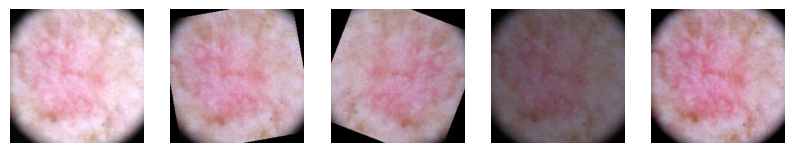

Displaying images for category: Basal Cell Carcinoma


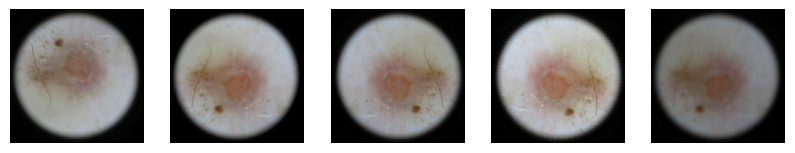

Displaying images for category: Dermatofibroma


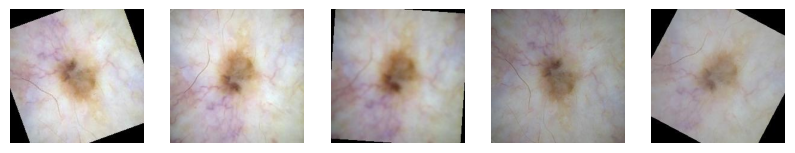

Displaying images for category: Melanoma


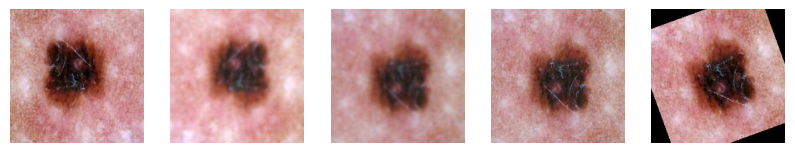

Displaying images for category: Nevus


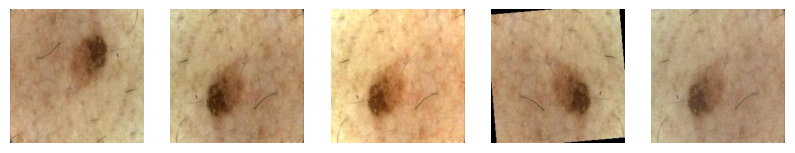

Displaying images for category: Pigmented Benign Keratosis


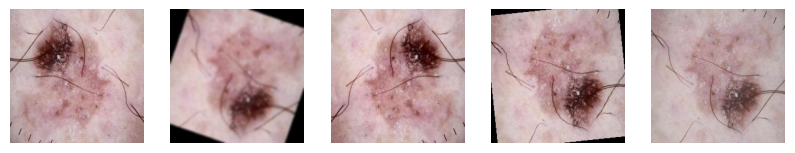

Displaying images for category: Seborrheic Keratosis


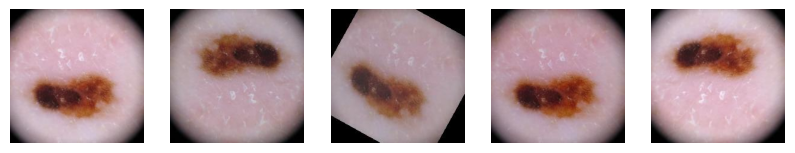

Displaying images for category: Squamous Cell Carcinoma


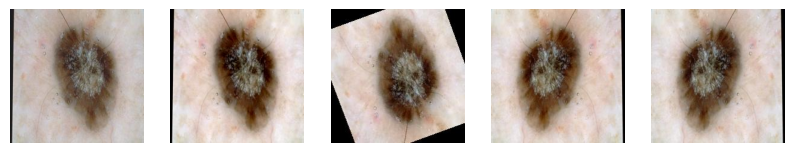

Displaying images for category: Vascular Lesion


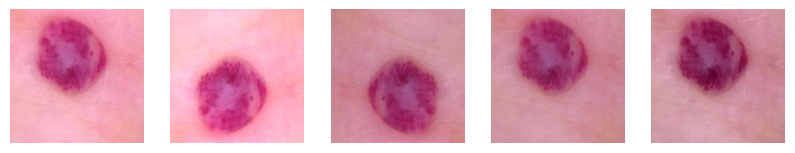

In [14]:
parent_dir = 'Data_Augmentation'

# Automatically retrieve the list of categories (subdirectories) from the parent directory
categories = [d for d in os.listdir(parent_dir) if os.path.isdir(os.path.join(parent_dir, d))]

# Function to display images from each category
def display_images_for_category(category_dir, num_images=10):
    image_files = [f for f in os.listdir(category_dir)]
    
    # Only proceed if there are images to display
    if len(image_files) == 0:
        print(f"No images found in {category_dir}. Skipping...")
        return
    
    # Display at least 5 images or all if fewer are available
    image_files = image_files[:num_images]
    
    # Set up the figure to display images
    fig, axes = plt.subplots(1, len(image_files), figsize=(10, 5))
    
    # If there's only one image, axes is not a list, handle that case
    if len(image_files) == 1:
        axes = [axes]
    
    # Display each image
    for i, image_file in enumerate(image_files):
        img_path = os.path.join(category_dir, image_file)
        img = mpimg.imread(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')  # Hide axes
#         axes[i].set_title(f'{os.path.basename(category_dir)}')

    plt.show()

# Loop through each category and display at least 5 images
for category in categories:
    category_dir = os.path.join(parent_dir, category)
    if os.path.exists(category_dir):  # Check if the directory exists
        print(f"Displaying images for category: {category}")
        display_images_for_category(category_dir, num_images=5)
    else:
        print(f"Directory not found: {category_dir}")

4. Loading Dataset

In [15]:
# Directories for train, validation, and test sets
train_dir = 'Train'
val_dir = 'Validation'
test_dir = 'Test'

# Create an ImageDataGenerator for each set
# The rescale parameter normalizes pixel values from [0, 255] to [0, 1]
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load and normalize the training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize all images to 224x224
    batch_size=32,  # Number of images per batch
    class_mode='categorical'  # Adjust if your labels are binary or categorical
)

# Load and normalize the validation data
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Load and normalize the test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Shuffle should be False for test set to ensure proper evaluation
)

Found 26283 images belonging to 9 classes.
Found 3285 images belonging to 9 classes.
Found 3288 images belonging to 9 classes.


VGG16 Model - TRANSFER LEARNING

In [16]:
# Load the VGG16 model, excluding the top fully connected layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers to retain pre-trained weights
for layer in base_model.layers:
    layer.trainable = False

# Add custom fully connected layers on top of VGG16 base
x = base_model.output
x = Flatten()(x)  # Flatten the output from convolutional layers
x = Dense(512, activation='relu')(x)  # Fully connected layer with 512 units
x = Dropout(0.2)(x)  # Dropout for regularization
x = Dense(256, activation='relu')(x)  # Another fully connected layer with 256 units
x = Dropout(0.1)(x)

# Output layer with 'softmax' activation for multi-class classification
# There are 9 classes (for 9 skin diseases)
output_layer = Dense(9, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Summary of the model
model.summary()

58889256/58889256 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [17]:
import tensorflow as tf

# Check if TensorFlow is using GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [18]:
# Train the model using the generators
history = model.fit(
    train_generator,  # Training data generator
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,  # Validation data generator
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=50  # Number of epochs
)

Epoch 1/50
821/821 [==============================] - 245s 281ms/step - loss: 1.6975 - accuracy: 0.3880 - val_loss: 1.4396 - val_accuracy: 0.4660
Epoch 2/50
821/821 [==============================] - 229s 279ms/step - loss: 1.3326 - accuracy: 0.5254 - val_loss: 1.2897 - val_accuracy: 0.5331
Epoch 3/50
821/821 [==============================] - 227s 276ms/step - loss: 1.1591 - accuracy: 0.5877 - val_loss: 1.1016 - val_accuracy: 0.6020
Epoch 4/50
821/821 [==============================] - 226s 275ms/step - loss: 1.0159 - accuracy: 0.6429 - val_loss: 1.0249 - val_accuracy: 0.6330
Epoch 5/50
821/821 [==============================] - 225s 274ms/step - loss: 0.9105 - accuracy: 0.6808 - val_loss: 0.9813 - val_accuracy: 0.6553
Epoch 6/50
821/821 [==============================] - 226s 276ms/step - loss: 0.8245 - accuracy: 0.7066 - val_loss: 0.9087 - val_accuracy: 0.6759
Epoch 7/50
821/821 [==============================] - 226s 275ms/step - loss: 0.7358 - accuracy: 0.7399 - val_loss: 0.8729 -

In [19]:
#Save the model
model.save('trained_model.h5')

MODEL EVALUATION

In [20]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

103/103 [==============================] - 31s 304ms/step - loss: 0.8617 - accuracy: 0.8096
Test Accuracy: 80.96%


7.2. Visualizing Training and Validation Accuracy and Loss

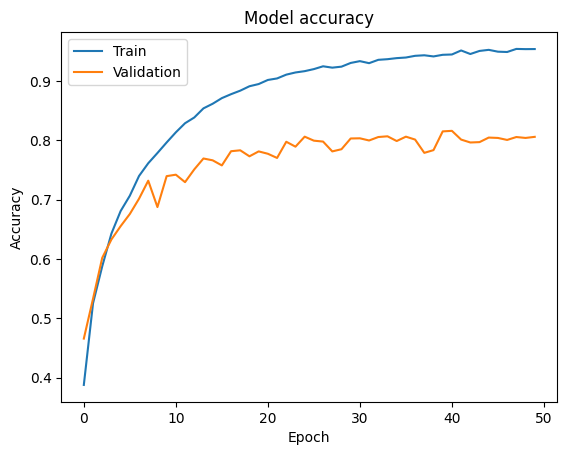

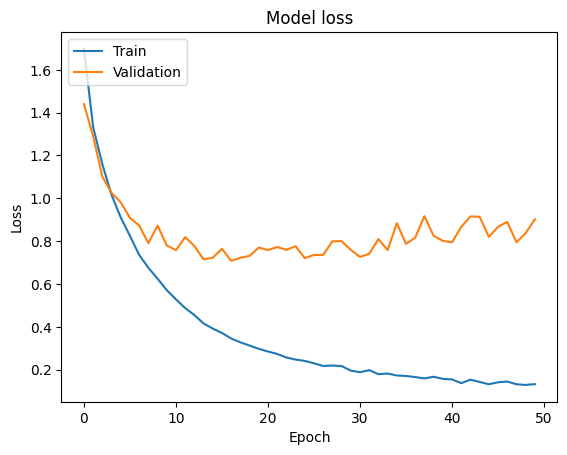

In [21]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

CONFUSION MATRIX

103/103 [==============================] - 24s 234ms/step
Length of true labels (y_true): 3288
Length of predicted labels (y_pred): 3288
                            precision    recall  f1-score   support

        Acitinic Keratosis       0.78      0.82      0.80       400
      Basal Cell Carcinoma       0.84      0.62      0.72       400
            Dermatofibroma       0.73      0.84      0.78       320
                  Melanoma       0.83      0.87      0.85       404
                     Nevus       0.91      0.89      0.90       400
Pigmented Benign Keratosis       0.76      0.95      0.84       400
      Seborrheic Keratosis       0.78      0.69      0.74       400
   Squamous Cell Carcinoma       0.84      0.75      0.79       332
           Vascular Lesion       0.87      0.87      0.87       232

                  accuracy                           0.81      3288
                 macro avg       0.82      0.81      0.81      3288
              weighted avg       0.81      0.

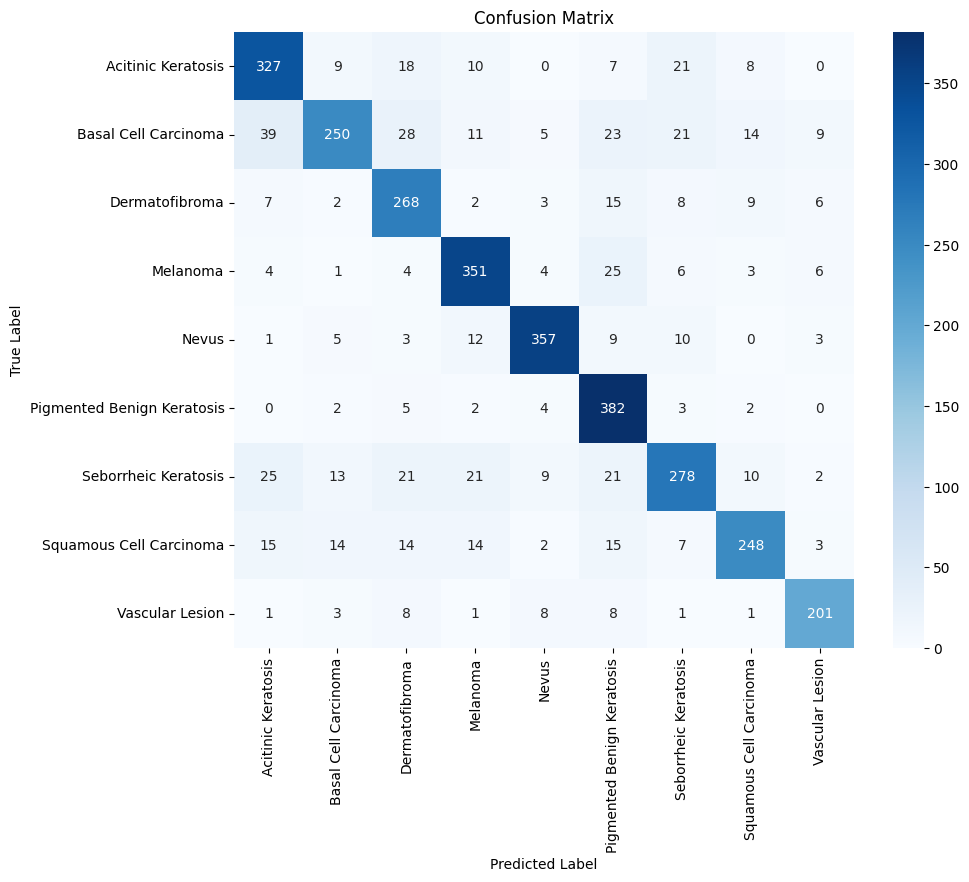

In [22]:
# Ensure the generator is reset
test_generator.reset()

# Calculate the correct number of steps
test_steps = math.ceil(test_generator.samples / test_generator.batch_size)

# Make predictions
predictions = model.predict(test_generator, steps=test_steps, verbose=1)

# Convert predicted probabilities to class labels
y_pred = np.argmax(predictions, axis=1)

# Get the true labels
y_true = test_generator.classes

# Check if the lengths of y_true and y_pred are consistent
print(f"Length of true labels (y_true): {len(y_true)}")
print(f"Length of predicted labels (y_pred): {len(y_pred)}")

# Ensure the length of y_true and y_pred match
if len(y_true) != len(y_pred):
    raise ValueError(f"Mismatch in number of true labels and predicted labels: {len(y_true)} vs {len(y_pred)}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Classification report
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Plotting confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()